In [27]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [13]:
dftrain = pd.read_pickle('data_train.p')
dftest = pd.read_pickle('data_test.p')

In [38]:
len(dftrain.columns)

114

In [15]:
extra_columns = ['business_id', 
                 'date', 
                 'text', 
                 'user_id', 
                 'BestNights',
                 'HairSpecializesIn',
                 'DietaryRestrictions',
                 'average_stars']
dummy_cols = ['NoiseLevel', 'WiFi', 'Smoking', 'AgesAllowed']
target = 'stars'

In [16]:
def data_to_model(raw_data, dummy_cols, extra_columns, normalize_using=None):
    df_X = raw_data.drop(extra_columns + dummy_cols + [target], axis=1)
    if normalize_using is not None:
        df_norm = normalize_using.drop(extra_columns + dummy_cols + [target], axis=1)
    df_y = raw_data[target]
    
    for dummy_col in dummy_cols:
        df_dummy = pd.get_dummies(raw_data[dummy_col], prefix=dummy_col)
        df_X = df_X.join(df_dummy)
        if normalize_using is not None:
            norm_dummy = pd.get_dummies(normalize_using[dummy_col], prefix=dummy_col)
            df_norm = df_norm.join(norm_dummy)
        
    if normalize_using is None:
        df_norm = df_X
        
    normalize(df_X, df_norm)
    return df_X.fillna(0), df_y


def normalize(df_X, normalize_using):
    # memory saving normalization
    for col in df_X.columns:
        # print('normalizing %s' % col)
        norm_mean = np.mean(normalize_using[col].astype(float))
        norm_std = np.std(normalize_using[col].astype(float))
        df_X[col] = (df_X[col].astype(float) - norm_mean) / norm_std
        
        
def mse_loss(preds, truths):
    assert len(preds) == len(truths)
    sse = 0.
    for i in range(len(preds)):
        sse += (preds[i] - truths[i]) ** 2
    return - sse / len(preds)

In [17]:
df_X, df_y = data_to_model(dftrain, dummy_cols, extra_columns, dftrain)
# df_Xval, df_yval = data_to_model(dfval, dummy_cols, extra_columns, dftrain)
df_Xtest, df_ytest = data_to_model(dftest, dummy_cols, extra_columns, dftrain)

In [18]:
X = df_X.values
y = df_y.values

### Naive Model

In [19]:
- np.mean((dftest['stars'] - dftest['avg_stars_bus']) ** 2)

-1.548369652113215

In [20]:
- np.mean((dftrain['stars'] - dftrain['avg_stars_bus']) ** 2)

-1.4694481861809072

### Test Data filling missing column

In [21]:
# filling missing dummies with 0
for col in df_X.columns:
    if col not in df_Xtest.columns:
        df_Xtest[col] = 0

In [22]:
arr_classes = np.arange(0,5,1) + 1

### What is baseline random?

In [22]:
from tqdm import tqdm_notebook as tqdm

rand_mses = []

for i in tqdm(range(100)):
    rand_vals = np.random.randint(1, 6, len(df_y[:10000]))
    rand_mse = mse_loss(rand_vals, df_y[:10000])
    rand_mses.append(rand_mse)

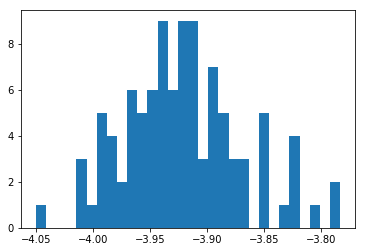

In [23]:
plt.hist(rand_mses, bins=30)
plt.show()

### Baseline MSE = 3.92

In [25]:
np.mean(rand_mses)

-3.9213959999999997

### statsmodels

In [40]:
import statsmodels.api as sm

In [41]:
res = sm.OLS(df_y, df_X).fit()

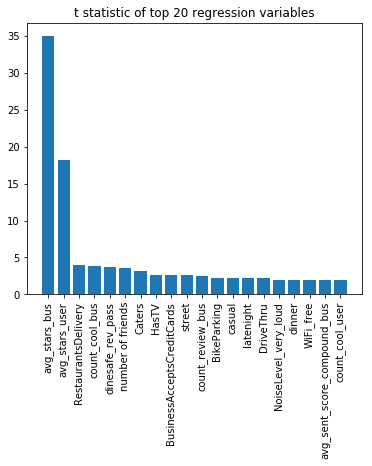

In [42]:
plt.figure(figsize=(6,5))
s = np.abs(res.tvalues).sort_values(ascending=False)
plt.bar(s.index[:20], s.values[:20])
plt.title('t statistic of top 20 regression variables')
plt.xticks(rotation=90)
plt.show()

## For each model let's search over predefined hparameters

## Logistic Regression Search

In [24]:
preds_dict = {}

In [25]:
from sklearn.model_selection import TimeSeriesSplit

In [35]:
Cs = [0.001, 0.01, 0.1, 1, 10]
res_dict = {}
preds_dict['LR'] = {}

for C in tqdm(Cs):
    # cross validation
    lrf = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=C)
    scores_lrf = cross_val_score(lrf, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
    mean_score = np.mean(scores_lrf)
    std_score = np.std(scores_lrf)

    preds = lrf.fit(df_X, df_y).predict_proba(df_X).dot(arr_classes)
    preds_dict['LR'][C] = preds
    
    res_dict[C] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
    }
    
df_lr = pd.DataFrame(res_dict).T
df_lr

,cv_mean,cv_std
0.001,-2.109800,0.280761
0.010,-2.120686,0.277470
0.100,-2.125119,0.275321
1.000,-2.126254,0.274943
10.000,-2.125776,0.273890


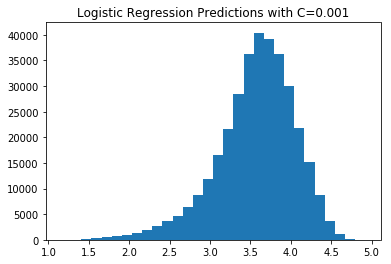

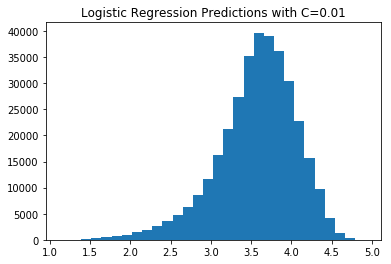

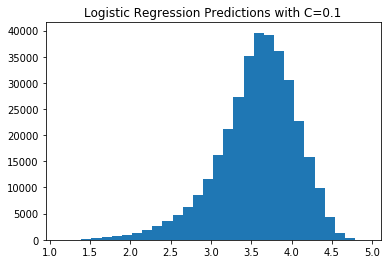

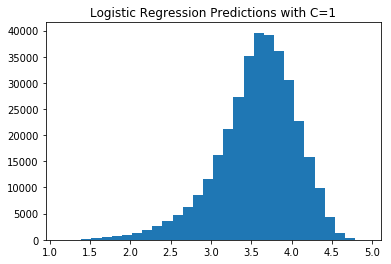

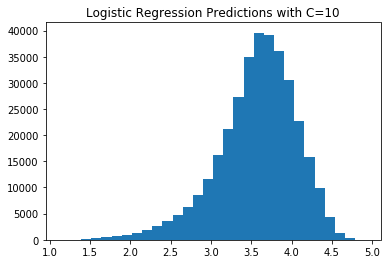

In [36]:
for C in Cs:
    plt.hist(preds_dict['LR'][C], bins=30)
    plt.title('Logistic Regression Predictions with C=%s' % C)
    plt.show()

## Ridge Regression Search - L2 regularization

In [37]:
ridge_alphas = [0.001, 0.01, 0.1, 1, 10]
res_dict = {}
preds_dict['Ridge'] = {}

for alpha in tqdm(ridge_alphas):
    # cross validation
    mod = Ridge(alpha=alpha)
    scores = cross_val_score(mod, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_X, df_y)
    preds = m.predict(df_X)
    
    preds_dict['Ridge'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
    }
    
df_rd = pd.DataFrame(res_dict).T
df_rd

,cv_mean,cv_std
0.001,-1.445271,0.128815
0.010,-1.445261,0.128819
0.100,-1.445157,0.128858
1.000,-1.444230,0.129216
10.000,-1.440115,0.130913


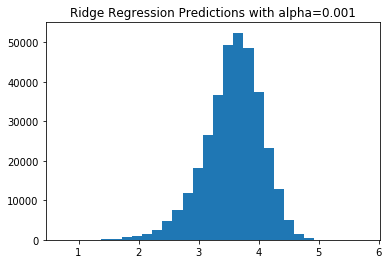

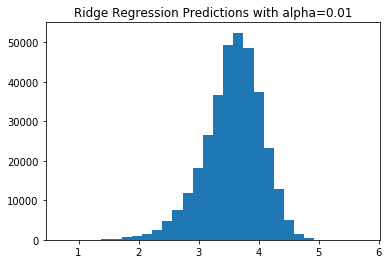

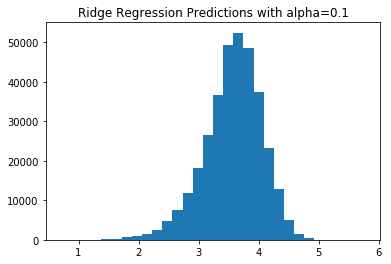

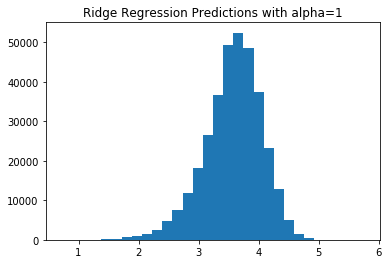

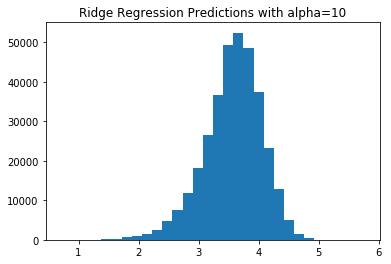

In [38]:
for alpha in ridge_alphas:
    plt.hist(preds_dict['Ridge'][alpha], bins=30)
    plt.title('Ridge Regression Predictions with alpha=%s' % alpha)
    plt.show()

## Lasso Search - L1 regularization

In [28]:
lasso_alphas = [0.01, 0.05, 0.1, 1, 10]
res_dict = {}
preds_dict['Lasso'] = {}

for alpha in tqdm(lasso_alphas):
    # cross validation
    mod = Lasso(alpha=alpha)
    scores = cross_val_score(mod, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_X, df_y)
    preds = m.predict(df_X)
    
    preds_dict['Lasso'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
    }
    
df_ls = pd.DataFrame(res_dict).T
df_ls

,cv_mean,cv_std
0.01,-1.440335,0.136336
0.05,-1.449778,0.134698
0.10,-1.470334,0.128482
1.00,-1.680168,0.147486
10.00,-1.680168,0.147486


In [ ]:
for alpha in lasso_alphas:
    plt.hist(preds_dict['Lasso'][alpha], bins=30)
    plt.title('Lasso Regression Predictions with alpha=%s' % alpha)
    plt.show()

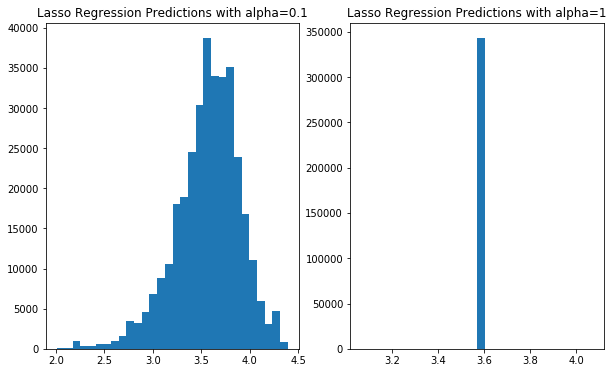

In [32]:
f, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].hist(preds_dict['Lasso'][0.1], bins=30)
axs[0].set_title('Lasso Regression Predictions with alpha=%s' % 0.1)

axs[1].hist(preds_dict['Lasso'][1], bins=30)
axs[1].set_title('Lasso Regression Predictions with alpha=%s' % 1)

plt.show()

## Elastic Net Search - L1 + L2 regularization

In [34]:
en_alphas = [0.01, 0.05, 0.1, 1, 10]
res_dict = {}
preds_dict['ElasticNet'] = {}

for alpha in tqdm(en_alphas):
    # cross validation
    mod = ElasticNet(alpha=alpha/2)
    scores = cross_val_score(mod, df_X, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_X, df_y)
    preds = m.predict(df_X)
    
    preds_dict['ElasticNet'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
    }
    
df_en = pd.DataFrame(res_dict).T
df_en

,cv_mean,cv_std
0.01,-1.436642,0.134514
0.05,-1.440463,0.135652
0.10,-1.444110,0.134384
1.00,-1.601148,0.118808
10.00,-1.680168,0.147486


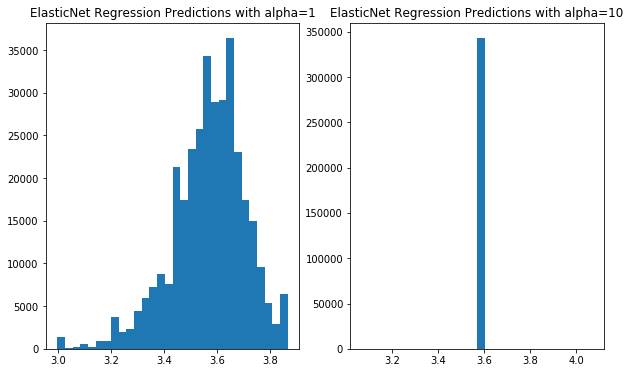

In [37]:
f, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].hist(preds_dict['ElasticNet'][1], bins=30)
axs[0].set_title('ElasticNet Regression Predictions with alpha=%s' % 1)

axs[1].hist(preds_dict['ElasticNet'][10], bins=30)
axs[1].set_title('ElasticNet Regression Predictions with alpha=%s' % 10)

plt.show()

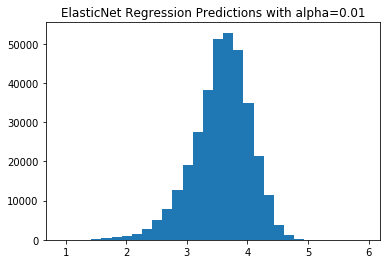

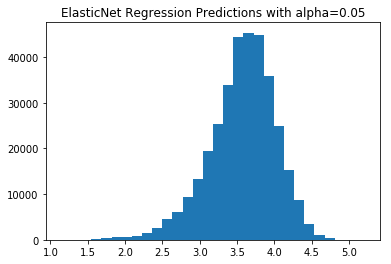

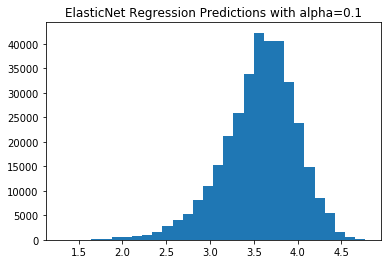

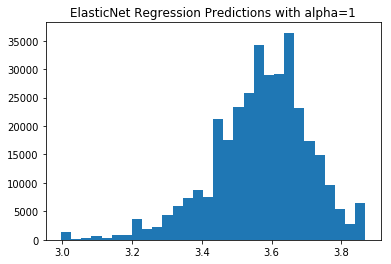

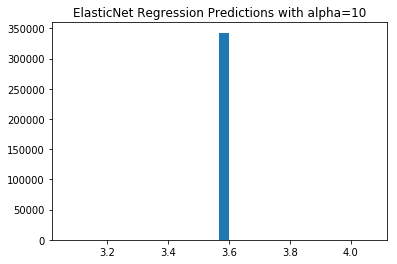

In [42]:
for alpha in en_alphas:
    plt.hist(preds_dict['ElasticNet'][alpha], bins=30)
    plt.title('ElasticNet Regression Predictions with alpha=%s' % alpha)
    plt.show()

# Using only to top 1/2 of important columns

In [47]:
used_cols = s[:len(s)//2].index

In [49]:
df_Xx = df_X[used_cols] 
df_Xtestx = df_Xtest[used_cols]

### Logistic Regression

In [50]:
preds_dictx = {}

In [52]:
Cs = [0.001, 0.01, 0.1, 1, 10]
res_dict = {}
preds_dictx['LR'] = {}

for C in tqdm(Cs):
    # cross validation
    lrf = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=C)
    scores_lrf = cross_val_score(lrf, df_Xx, df_y, cv=TimeSeriesSplit(n_splits=3), 
                                 scoring='neg_mean_squared_error')
    mean_score = np.mean(scores_lrf)
    std_score = np.std(scores_lrf)
    
    # validation set
    m = lrf.fit(df_Xx, df_y)
    preds = m.predict_proba(df_Xx).dot(arr_classes)
    
    preds_dictx['LR'][C] = preds
    
    res_dict[C] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
    }
    
df_lrx = pd.DataFrame(res_dict).T
df_lrx

,cv_mean,cv_std
0.001,-2.086910,0.284031
0.010,-2.100270,0.277783
0.100,-2.101592,0.278055
1.000,-2.101705,0.277630
10.000,-2.101689,0.277483


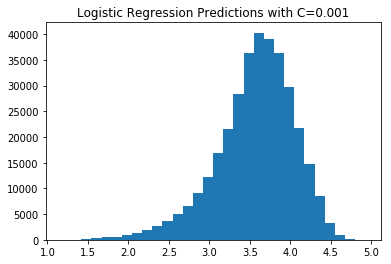

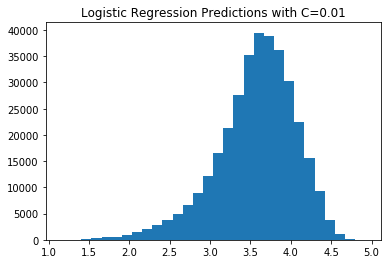

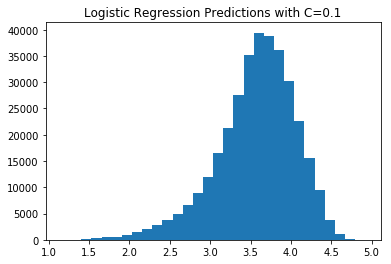

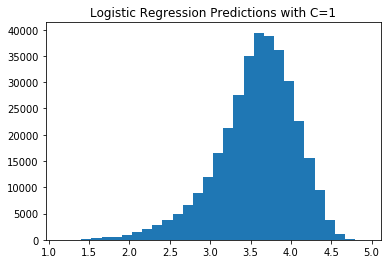

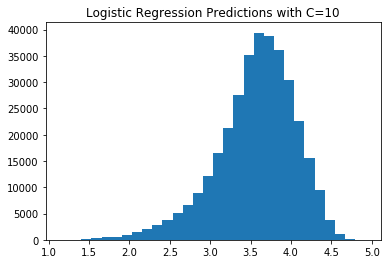

In [53]:
for C in Cs:
    plt.hist(preds_dictx['LR'][C], bins=30)
    plt.title('Logistic Regression Predictions with C=%s' % C)
    plt.show()

### Ridge

In [54]:
ridge_alphas = [0.001, 0.01, 0.1, 1, 10]
res_dict = {}
preds_dictx['Ridge'] = {}

for alpha in tqdm(ridge_alphas):
    # cross validation
    mod = Ridge(alpha=alpha)
    scores = cross_val_score(mod, df_Xx, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_Xx, df_y)
    preds = m.predict(df_Xx)
    
    preds_dictx['Ridge'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
    }
    
df_rd = pd.DataFrame(res_dict).T
df_rd

,cv_mean,cv_std
0.001,-1.437123,0.131767
0.010,-1.437123,0.131767
0.100,-1.437121,0.131768
1.000,-1.437103,0.131777
10.000,-1.436934,0.131864


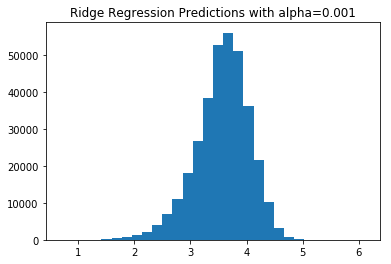

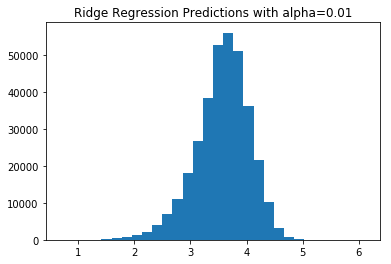

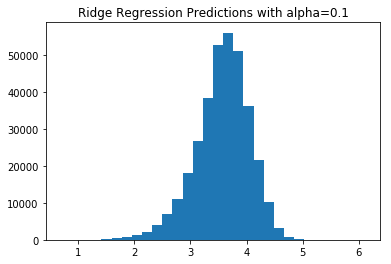

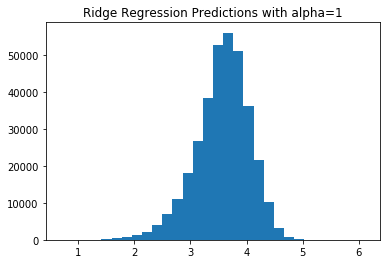

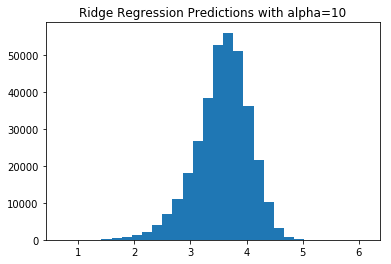

In [56]:
for alpha in ridge_alphas:
    plt.hist(preds_dictx['Ridge'][alpha], bins=30)
    plt.title('Ridge Regression Predictions with alpha=%s' % alpha)
    plt.show()

### Lasso

In [57]:
lasso_alphas = [0.01, 0.05, 0.1, 1, 10]
res_dict = {}
preds_dictx['Lasso'] = {}

for alpha in tqdm(lasso_alphas):
    # cross validation
    mod = Lasso(alpha=alpha)
    scores = cross_val_score(mod, df_Xx, df_y, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_Xx, df_y)
    preds = m.predict(df_Xx)
    
    preds_dictx['Lasso'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
    }
    
df_ls = pd.DataFrame(res_dict).T
df_ls

,cv_mean,cv_std
0.01,-1.440463,0.136409
0.05,-1.449779,0.134698
0.10,-1.470334,0.128482
1.00,-1.680168,0.147486
10.00,-1.680168,0.147486


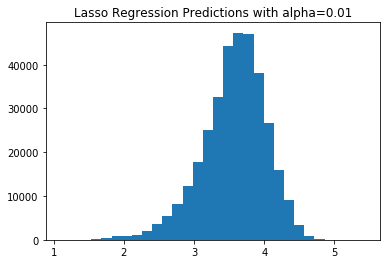

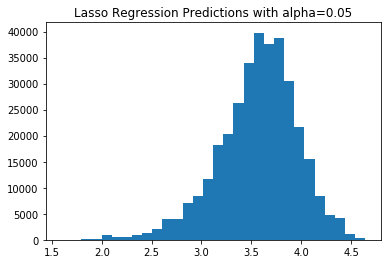

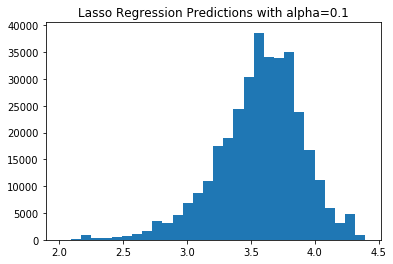

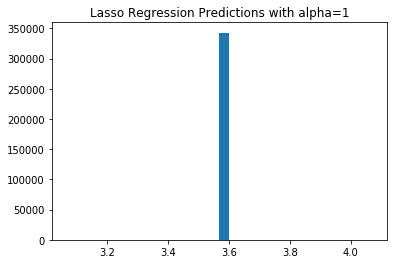

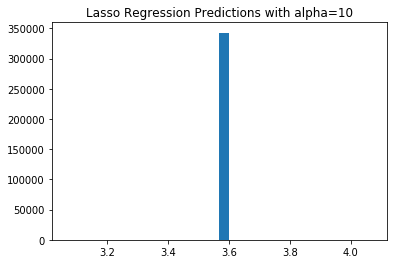

In [58]:
for alpha in lasso_alphas:
    plt.hist(preds_dictx['Lasso'][alpha], bins=30)
    plt.title('Lasso Regression Predictions with alpha=%s' % alpha)
    plt.show()

### Elastic Net

In [59]:
en_alphas = [0.01, 0.05, 0.1, 1, 10]
res_dict = {}
preds_dictx['ElasticNet'] = {}

for alpha in tqdm(en_alphas):
    # cross validation
    mod = ElasticNet(alpha=alpha/2)
    scores = cross_val_score(mod, df_Xx, df_y, cv=TimeSeriesSplit(n_splits=3), 
                             scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_Xx, df_y)
    preds = m.predict(df_Xx)
    
    preds_dictx['ElasticNet'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
    }
    
df_en = pd.DataFrame(res_dict).T
df_en

,cv_mean,cv_std
0.01,-1.436470,0.134495
0.05,-1.440656,0.135711
0.10,-1.444109,0.134383
1.00,-1.601148,0.118808
10.00,-1.680168,0.147486


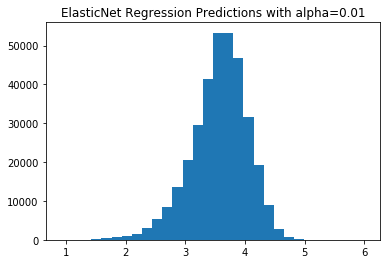

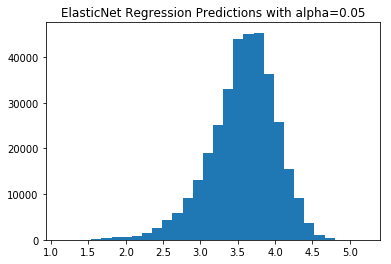

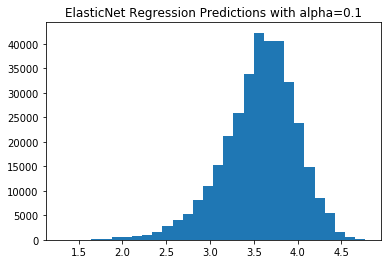

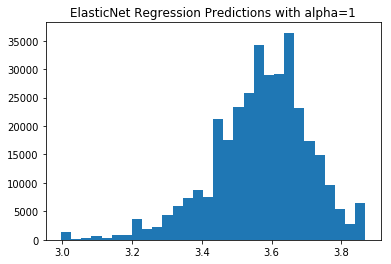

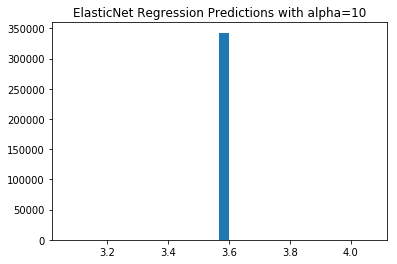

In [60]:
for alpha in en_alphas:
    plt.hist(preds_dictx['ElasticNet'][alpha], bins=30)
    plt.title('ElasticNet Regression Predictions with alpha=%s' % alpha)
    plt.show()